In [1]:
import h5py
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import pickle

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin

# -----------------------------
# 1. Function for Patch Extraction
# -----------------------------
def extract_patch(image, center, patch_size):
    """
    Extract a square patch from the image centered at the given coordinate.
    Assumes image shape is (height, width, channels) and center is (x, y).
    """
    x, y = int(center[0]), int(center[1])
    half_size = patch_size // 2
    y_min = max(y - half_size, 0)
    y_max = min(y + half_size, image.shape[0])
    x_min = max(x - half_size, 0)
    x_max = min(x + half_size, image.shape[1])
    patch = image[y_min:y_max, x_min:x_max, :]
    return patch

# -----------------------------
# 2. Custom Transformer to Extract Color Features from Patches
# -----------------------------
class ColorFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, image, patch_size):
        """
        Parameters:
          image (ndarray): The whole-slide HE image as a numpy array.
          patch_size (int): Size (in pixels) of the square patch to extract.
        """
        self.image = image
        self.patch_size = patch_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        # For each coordinate (x, y), extract the patch and compute mean color
        for coord in X:
            patch = extract_patch(self.image, coord, self.patch_size)
            # Compute the average color for each channel (R, G, B)
            avg_color = np.mean(patch, axis=(0,1))  # Result is a vector of 3 values
            features.append(avg_color)
        return np.array(features)

# -----------------------------
# 3. Pipeline Class for the Elucidata Challenge with Color Features
# -----------------------------
class CellTypePipeline:
    """
    Pipeline for loading data, extracting simple color features from image patches,
    training a multi-output regression model, and generating a submission file.
    This simplified version uses the mean color of the patch as the feature.
    Optionally, features can be cached to speed up re-runs.
    """
    
    def __init__(self, h5_file_path, patch_size=64):
        self.h5_file_path = h5_file_path
        self.patch_size = patch_size
        self.train_spot_tables = {}
        self.train_images = {}
        self.cell_type_columns = None
        self.feature_extractor_pipeline = None

    def load_train_data(self):
        """
        Load training spot data from the H5 file and store each slide as a DataFrame.
        Assumes first two columns are x and y coordinates and the rest are cell type abundances.
        """
        with h5py.File(self.h5_file_path, "r") as f:
            train_spots = f["spots/Train"]
            for slide_name in train_spots.keys():
                spot_array = np.array(train_spots[slide_name])
                # Create column names: first two are x and y; rest are C1...C35.
                df = pd.DataFrame(spot_array, columns=["x", "y"] + [f"C{i}" for i in range(1, 36)])
                self.train_spot_tables[slide_name] = df
        print("Training spot data loaded successfully.")
        
    def load_train_images(self):
        """
        Load training HE images from the H5 file.
        Adjust the key if your H5 file uses a different naming convention.
        """
        with h5py.File(self.h5_file_path, "r") as f:
            train_imgs = f["images/Train"]
            for slide_name in train_imgs.keys():
                image_array = np.array(train_imgs[slide_name])
                self.train_images[slide_name] = image_array
        print("Training images loaded successfully.")

    def load_test_data(self, slide_id):
        """
        Load test spot data for a given slide.
        """
        with h5py.File(self.h5_file_path, "r") as f:
            test_spots = f["spots/Test"]
            if slide_id not in test_spots:
                raise ValueError(f"Slide {slide_id} not found in test spot data.")
            spot_array = np.array(test_spots[slide_id])
            test_df = pd.DataFrame(spot_array, columns=["x", "y"])
        print(f"Test spot data for slide {slide_id} loaded successfully.")
        return test_df

    def load_test_image(self, slide_id):
        """
        Load test HE image for a given slide.
        """
        with h5py.File(self.h5_file_path, "r") as f:
            test_imgs = f["images/Test"]
            if slide_id not in test_imgs:
                raise ValueError(f"Slide {slide_id} not found in test images.")
            image_array = np.array(test_imgs[slide_id])
        print(f"Test image for slide {slide_id} loaded successfully.")
        return image_array

    def prepare_training_set(self, slide_id='S_1', cache_path=None):
        """
        Prepare training features and targets for a given slide.
        Uses the HE image to extract patches and compute the mean color of each patch.
        If cache_path is provided and exists, the method will load cached features.
        Otherwise, it computes the features and saves them to the provided cache_path.
        """
        if cache_path is not None and os.path.exists(cache_path):
            print(f"Loading cached training features from {cache_path} for slide {slide_id} ...")
            with open(cache_path, "rb") as f:
                X_features, y = pickle.load(f)
            return X_features, y
        
        if slide_id not in self.train_spot_tables:
            raise ValueError(f"Slide {slide_id} not found in training spot data.")
        if slide_id not in self.train_images:
            raise ValueError(f"Slide {slide_id} image not loaded.")
            
        df = self.train_spot_tables[slide_id]
        feature_cols = ['x', 'y']
        target_cols = [col for col in df.columns if col not in feature_cols]
        self.cell_type_columns = target_cols  # Assumed consistent across slides
        
        X_coords = df[feature_cols].values.astype(float)
        y = df[target_cols].values.astype(float)
        
        he_image = self.train_images[slide_id]
        color_extractor = ColorFeatureExtractor(he_image, self.patch_size)
        self.feature_extractor_pipeline = Pipeline([
            ('color_extractor', color_extractor),
            ('scaler', StandardScaler())
        ])
        print(f"Extracting color features for slide {slide_id} ...")
        X_features = self.feature_extractor_pipeline.fit_transform(X_coords)
        
        if cache_path is not None:
            print(f"Saving training features for slide {slide_id} to {cache_path} ...")
            with open(cache_path, "wb") as f:
                pickle.dump((X_features, y), f)
                
        print(f"Extracted color features for slide {slide_id}.")
        return X_features, y

    def prepare_all_training_set(self, cache_dir=None):
        """
        Prepare training features and targets for all slides in the training set (S_1 to S_6).
        If cache_dir is provided, each slide will use a separate cache file.
        Returns:
            X_all (ndarray): Concatenated features for all slides.
            y_all (ndarray): Concatenated target values for all slides.
        """
        X_list = []
        y_list = []
        for slide_id in sorted(self.train_spot_tables.keys()):
            slide_cache_path = os.path.join(cache_dir, f"train_features_{slide_id}.pkl") if cache_dir else None
            X, y = self.prepare_training_set(slide_id=slide_id, cache_path=slide_cache_path)
            X_list.append(X)
            y_list.append(y)
        X_all = np.concatenate(X_list, axis=0)
        y_all = np.concatenate(y_list, axis=0)
        print("All training features extracted and concatenated.")
        return X_all, y_all

    def build_regression_pipeline(self):
        """
        Build and return a regression pipeline that uses the pre-extracted color features.
        """
        pipeline = Pipeline([
            ('regressor', MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)))
        ])
        return pipeline

    def train(self, X, y):
        """
        Train the regression model on the provided features and targets.
        """
        reg_pipeline = self.build_regression_pipeline()
        reg_pipeline.fit(X, y)
        print("Regression model training complete.")
        return reg_pipeline

    def predict(self, reg_model, X_test):
        """
        Predict cell type abundances on test features.
        """
        predictions = reg_model.predict(X_test)
        return predictions

    def create_submission(self, test_df, predictions, submission_filename="submission.csv"):
        """
        Create a submission CSV file with predicted cell type abundances.
        """
        pred_df = pd.DataFrame(predictions, columns=self.cell_type_columns, index=test_df.index)
        pred_df.insert(0, 'ID', pred_df.index)
        pred_df.to_csv(submission_filename, index=False)
        print(f"Submission file '{submission_filename}' created!")

    # -----------------------------
    # Visualization Methods
    # -----------------------------
    def visualize_spot_overlay(self, slide_id, flip_y=False):
        """
        Visualize the overlay of spot coordinates on the HE slide image.
        Optionally, flip the y-axis if needed.
        """
        if slide_id not in self.train_images or slide_id not in self.train_spot_tables:
            raise ValueError(f"Slide {slide_id} data not found.")
        image = self.train_images[slide_id]
        df = self.train_spot_tables[slide_id]
        coords = df[['x', 'y']].values.astype(float)
        if flip_y:
            coords[:, 1] = image.shape[0] - coords[:, 1]
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.scatter(coords[:, 0], coords[:, 1], marker='o', color='red', s=25)
        plt.title(f"Overlay of Spot Coordinates for Slide {slide_id}")
        plt.show()

    def visualize_extracted_patches(self, slide_id, num_patches=5, flip_y=False):
        """
        Visualize a few extracted patches from the slide to verify correct extraction.
        """
        if slide_id not in self.train_images or slide_id not in self.train_spot_tables:
            raise ValueError(f"Slide {slide_id} data not found.")
        image = self.train_images[slide_id]
        df = self.train_spot_tables[slide_id]
        coords = df[['x', 'y']].values.astype(float)
        if flip_y:
            coords[:, 1] = image.shape[0] - coords[:, 1]
        fig, axes = plt.subplots(1, num_patches, figsize=(num_patches * 3, 3))
        for i in range(num_patches):
            patch = extract_patch(image, coords[i], self.patch_size)
            axes[i].imshow(patch)
            axes[i].set_title(f"Patch {i}")
            axes[i].axis("off")
        plt.suptitle(f"Extracted Patches for Slide {slide_id}")
        plt.show()

    def visualize_cnn_input(self, slide_id, index=0, flip_y=False):
        """
        Visualize the resized patch for a given spot index with an overlay of the spot position.
        Since we are only using color features, this shows the patch (resized to 224x224)
        with a red "x" marking the spot's relative position.
        """
        if slide_id not in self.train_images or slide_id not in self.train_spot_tables:
            raise ValueError(f"Slide {slide_id} data not found.")
        image = self.train_images[slide_id]
        df = self.train_spot_tables[slide_id]
        coords = df[['x', 'y']].values.astype(float)
        if flip_y:
            coords[:, 1] = image.shape[0] - coords[:, 1]
        coord = coords[index]
        half_size = self.patch_size // 2
        x = int(coord[0])
        y = int(coord[1])
        x_min = max(x - half_size, 0)
        y_min = max(y - half_size, 0)
        patch = extract_patch(image, coord, self.patch_size)
        patch_resized = cv2.resize(patch, (224, 224))
        rel_x = x - x_min
        rel_y = y - y_min
        scale_x = 224 / patch.shape[1]
        scale_y = 224 / patch.shape[0]
        spot_resized_x = rel_x * scale_x
        spot_resized_y = rel_y * scale_y
        plt.figure(figsize=(5, 5))
        plt.imshow(patch_resized)
        plt.scatter([spot_resized_x], [spot_resized_y], marker='x', color='red', s=50)
        plt.title(f"Resized Patch with Spot Overlay for Slide {slide_id}, Index {index}")
        plt.axis("off")
        plt.show()



Training spot data loaded successfully.
Training images loaded successfully.


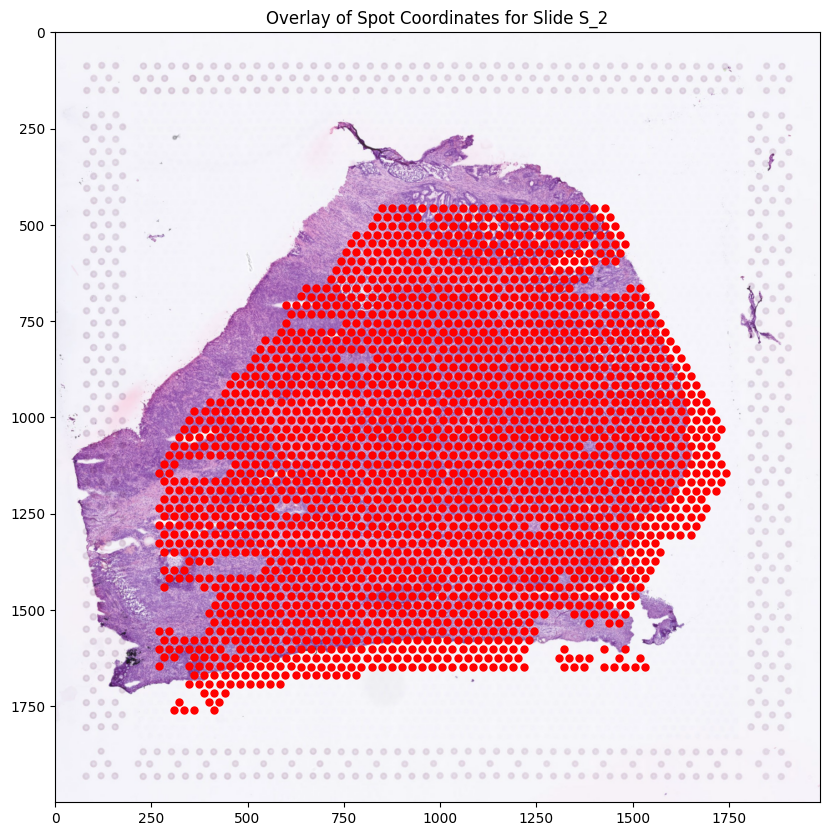

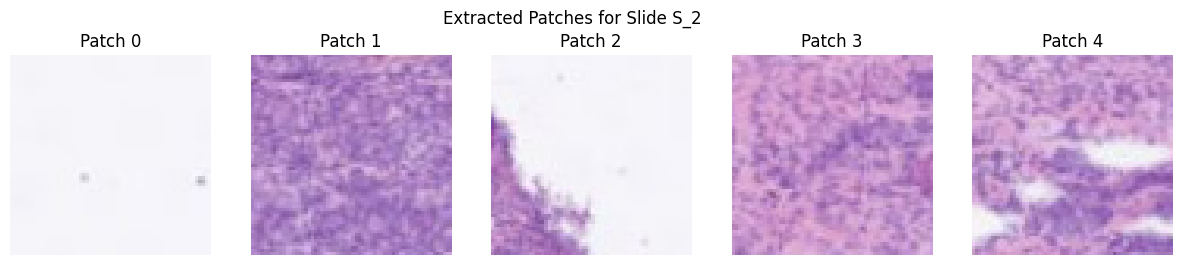

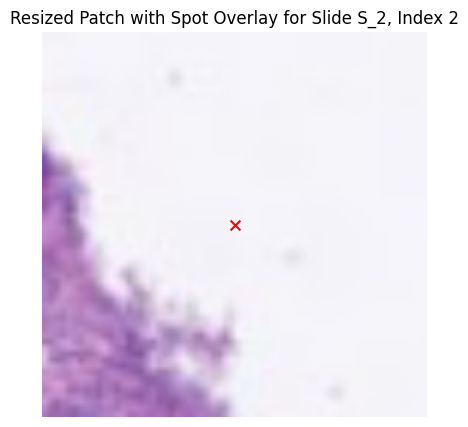

In [2]:
# -----------------------------
# 4. Example Usage with Caching and Visualization Options
# -----------------------------
h5_file_path = "/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5"

train_cache_dir = "train_features_cache"
os.makedirs(train_cache_dir, exist_ok=True)
test_cache_path = "test_features_S_7.pkl"

pipeline_obj = CellTypePipeline(h5_file_path, patch_size=64)

# Load training spots and images
pipeline_obj.load_train_data()
pipeline_obj.load_train_images()

# Visualize overlay of spots on a training slide (e.g., S_1)
pipeline_obj.visualize_spot_overlay(slide_id='S_2', flip_y=False)

# Visualize a few extracted patches from slide S_1
pipeline_obj.visualize_extracted_patches(slide_id='S_2', num_patches=5, flip_y=False)

# Visualize a resized patch with the spot overlay from slide S_1 (index 0)
pipeline_obj.visualize_cnn_input(slide_id='S_2', index=2, flip_y=False)


In [3]:

# Prepare training features from all slides (S_1 to S_6)
X_train, y_train = pipeline_obj.prepare_all_training_set(cache_dir=train_cache_dir)

# Train regression model on extracted color features
reg_model = pipeline_obj.train(X_train, y_train)

# Load test data and image for slide S_7
test_df = pipeline_obj.load_test_data(slide_id='S_7')
test_image = pipeline_obj.load_test_image(slide_id='S_7')




Extracting color features for slide S_1 ...
Saving training features for slide S_1 to train_features_cache/train_features_S_1.pkl ...
Extracted color features for slide S_1.
Extracting color features for slide S_2 ...
Saving training features for slide S_2 to train_features_cache/train_features_S_2.pkl ...
Extracted color features for slide S_2.
Extracting color features for slide S_3 ...
Saving training features for slide S_3 to train_features_cache/train_features_S_3.pkl ...
Extracted color features for slide S_3.
Extracting color features for slide S_4 ...
Saving training features for slide S_4 to train_features_cache/train_features_S_4.pkl ...
Extracted color features for slide S_4.
Extracting color features for slide S_5 ...
Saving training features for slide S_5 to train_features_cache/train_features_S_5.pkl ...
Extracted color features for slide S_5.
Extracting color features for slide S_6 ...
Saving training features for slide S_6 to train_features_cache/train_features_S_6.pkl 

In [4]:
X_train

array([[-0.6846976 , -0.53238815, -0.2788713 ],
       [ 1.9545486 ,  1.6547554 ,  1.426655  ],
       [ 0.06193917, -0.03825939, -0.1964026 ],
       ...,
       [ 1.4306291 ,  1.5229253 ,  1.3961072 ],
       [-1.4448886 , -1.3120669 , -1.2342929 ],
       [ 0.57446176,  0.28416777,  0.41080505]], dtype=float32)

In [5]:
# Build a feature extractor for the test slide using its HE image
test_color_extractor = ColorFeatureExtractor(test_image, pipeline_obj.patch_size)
test_feature_pipeline = Pipeline([
    ('color_extractor', test_color_extractor),
    ('scaler', StandardScaler())
])
X_test_coords = test_df[['x', 'y']].values.astype(float)

if os.path.exists(test_cache_path):
    print(f"Loading cached test features from {test_cache_path} ...")
    with open(test_cache_path, "rb") as f:
        X_test_features = pickle.load(f)
else:
    print("Extracting color features for test data ...")
    X_test_features = test_feature_pipeline.fit_transform(X_test_coords)
    print(f"Saving test features to {test_cache_path} ...")
    with open(test_cache_path, "wb") as f:
        pickle.dump(X_test_features, f)



Extracting color features for test data ...
Saving test features to test_features_S_7.pkl ...


In [6]:
predictions = pipeline_obj.predict(reg_model, X_test_features)
pipeline_obj.create_submission(test_df, predictions, submission_filename="submission.csv")

Submission file 'submission.csv' created!
